# Natural Processing Language Project - Spotify Lyrics Sentiment Analysis

In [1]:
#Import Spotipy and LyricsGenius
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import lyricsgenius

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

**Accessing Spotify's API**

In [2]:
my_spotify_client_id = 'b453c963699c4c13846f476505bba7a2' #This is the public identifier of my account
my_spotify__client_secret = 'MY CONFIDENTIAL SECRET CLIENT GOES HERE' #I used my secret client but it is personal

# Using SpotifyClientCredentials to authenticate my credential
credentials = SpotifyClientCredentials(client_id=my_spotify_client_id, client_secret=my_spotify__client_secret)
spot = spotipy.Spotify(client_credentials_manager=credentials)

playlist_id = '37i9dQZEVXbMDoHDwVN2tF' #This is a public playlist ID of the top songs at the moment

**Collecting data from a Spotify playlist and storing it in a DataFrame**

In [3]:
playlist = spot.playlist_tracks(playlist_id, limit=100)

playlist_data = []

# Loop over the tracks and retrieve details
for s in playlist['items']:
    song = s['track']
    song_id = song['id'] #Track ID
    artist_name = song['artists'][0]['name']
    song_title = song['name'] # Song Title
    artist_id = song['artists'][0]['id']  #Grabs the first artist name
    
    artist_info = spot.artist(artist_id) #Return the artist with the given ID
    genre = artist_info['genres'][0] if artist_info['genres'] else "Unknown" #Grabbing song track genre
    
    # Get a couple features from teh track
    features = spot.audio_features(song_id)[0] #Grab only the first from the list

    # Song data to be stored in dict
    song_data = {
        'Title': song_title,
        'Artist': artist_name,
        'Genre': genre,
        'Popularity': song['popularity'],
    }
    
    playlist_data.append(song_data) #Store in dict

df = pd.DataFrame(playlist_data)
df

,Title,Artist,Genre,Popularity
0,Die With A Smile,Lady Gaga,art pop,99
1,APT.,ROSÉ,k-pop,97
2,BIRDS OF A FEATHER,Billie Eilish,art pop,97
3,Who,Jimin,k-pop,92
4,Tu Boda,Oscar Maydon,corrido,92
5,That’s So True,Gracie Abrams,alt z,90
6,Taste,Sabrina Carpenter,pop,94
7,Espresso,Sabrina Carpenter,pop,88
8,Sailor Song,Gigi Perez,bedroom pop,92
9,"Good Luck, Babe!",Chappell Roan,indie pop,94


## Data Analysis & EDA Section

In [4]:
df['Genre'].unique()

array(['art pop', 'k-pop', 'corrido', 'alt z', 'pop', 'bedroom pop',
       'indie pop', 'reggaeton', 'singer-songwriter pop',
       'canadian contemporary r&b', 'Unknown', 'dance pop', 'hip hop',
       'modern alternative rock', 'modern country pop', 'permanent wave',
       'garage rock', 'funk consciente', 'trap boricua',
       'irish singer-songwriter', 'rap', 'alternative metal',
       'indie folk', 'pov: indie', 'dfw rap', 'reggaeton chileno',
       'neo mellow'], dtype=object)

**_Adjusting all the different types of 'pop' unless it is 'k-pop' and also 'rock_**

In [5]:
# Adjusting the genre 
def adjust_genre(genre):
    if 'pop' in genre and genre != 'k-pop':
        return 'pop'
    elif 'rock' in genre:
        return 'rock'
    return genre

df['Genre'] = df['Genre'].apply(adjust_genre)

In [6]:
df['Genre'].unique()

array(['pop', 'k-pop', 'corrido', 'alt z', 'reggaeton',
       'canadian contemporary r&b', 'Unknown', 'hip hop', 'rock',
       'permanent wave', 'funk consciente', 'trap boricua',
       'irish singer-songwriter', 'rap', 'alternative metal',
       'indie folk', 'pov: indie', 'dfw rap', 'reggaeton chileno',
       'neo mellow'], dtype=object)

In [7]:
df.dtypes

Title         object
Artist        object
Genre         object
Popularity     int64
dtype: object

In [8]:
df.isnull().sum()

Title         0
Artist        0
Genre         0
Popularity    0
dtype: int64

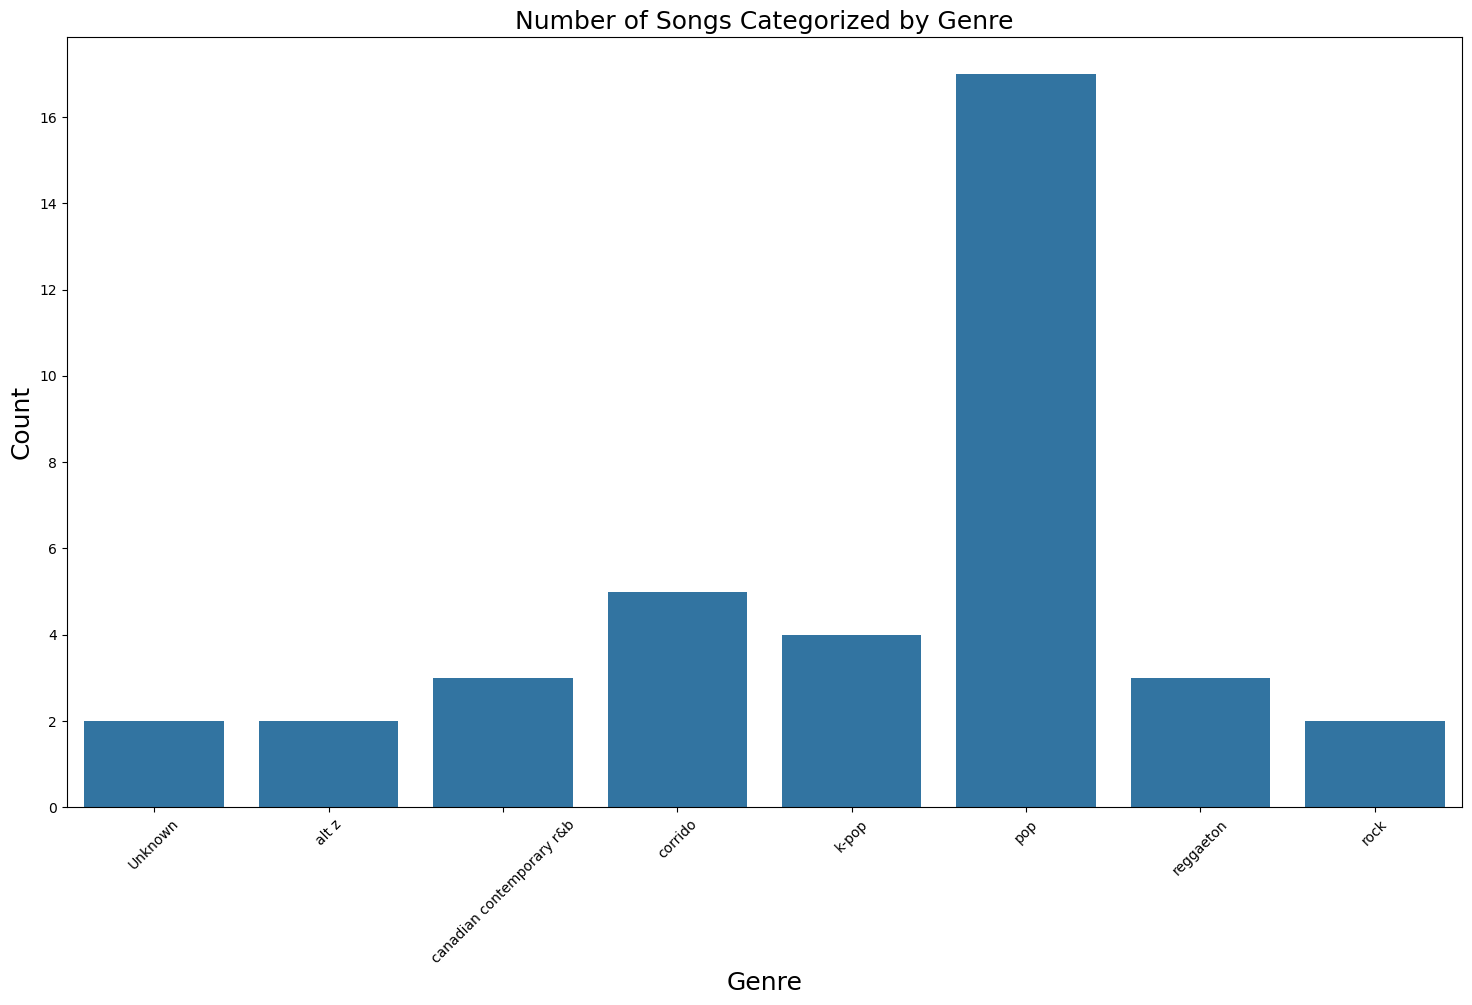

In [9]:
#Grouping data based on genre
group_genre = df.groupby('Genre').count()
group_genre.reset_index(inplace=True)
group_genre = group_genre[group_genre['Title'] > 1] #Remove only singles
#Plotting the bar plot
fig, ax = plt.subplots(figsize=(18,10))
bar_container = sns.barplot(x='Genre', y='Title', data=group_genre)
plt.title('Number of Songs Categorized by Genre', fontsize = 18)
ax.set_ylabel('Count', fontsize = 18)
ax.set_xlabel('Genre', fontsize = 18)
plt.xticks(rotation=45);

**Get Lyrics from Genius.com and a Sentiment Score for Each Song in the Playlist**

In [10]:
#Loading the pretrained model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # You can choose any sentiment model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

2024-11-10 11:52:23.666513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
#Using TextBlob to calculate the sentiment based on lyrics
def sentiment_score(text):

    blob = TextBlob(text) #create TextBlob object
    return blob.sentiment.polarity #This return a polsrity between -1 and 1

In [12]:
# Getting lyrics using lyricsgenius from genius.com
def get_lyrics(title, artist):
    song = genius.search_song(title, artist)
    if song:
        return song.lyrics
    else:
        return "Lyrics not found"

In [17]:
# Set up Genius API client
GENIUS_API_TOKEN = 'ZMuzJJl2kZCu6p9y5pMcLEV4kgJ4oT_iTJOCptdHjS2TQbpRxA8IccaGA6sUjRcy'
genius = lyricsgenius.Genius(GENIUS_API_TOKEN)

# Loop to get lyrics and apply sentiment analysis
lyrics_list = []
sentiment_scores = []

for index, row in df.iterrows():
    song_title = row['Title']
    artist_name = row['Artist']

    # Accessing Genius API to get lyrics
    lyrics = get_lyrics(song_title, artist_name)
    lyrics_list.append(lyrics)
    
    # Get sentiment score based on lyrics
    sentiment = sentiment_score(lyrics)
    sentiment_scores.append(sentiment)

#Storing lyrics and sentiment score in the df
df['Lyrics'] = lyrics_list
df['Sentiment Score'] = sentiment_scores

df.head()

Searching for "Die With A Smile" by Lady Gaga...
Done.
Searching for "APT." by ROSÉ...
Done.
Searching for "BIRDS OF A FEATHER" by Billie Eilish...
Done.
Searching for "Who" by Jimin...
Done.
Searching for "Tu Boda" by Oscar Maydon...
Done.
Searching for "That’s So True" by Gracie Abrams...
Done.
Searching for "Taste" by Sabrina Carpenter...
Done.
Searching for "Espresso" by Sabrina Carpenter...
Done.
Searching for "Sailor Song" by Gigi Perez...
Done.
Searching for "Good Luck, Babe!" by Chappell Roan...
Done.
Searching for "Si Antes Te Hubiera Conocido" by KAROL G...
Done.
Searching for "WILDFLOWER" by Billie Eilish...
Done.
Searching for "Beautiful Things" by Benson Boone...
Done.
Searching for "Timeless (with Playboi Carti)" by The Weeknd...
Done.
Searching for "Please Please Please" by Sabrina Carpenter...
Done.
Searching for "Lose Control" by Teddy Swims...
Done.
Searching for "That's What I Like" by Bruno Mars...
Done.
Searching for "+57" by KAROL G...
Done.
Searching for "EL LOKE

,Title,Artist,Genre,Popularity,Lyrics,Sentiment Score
0,Die With A Smile,Lady Gaga,pop,99,151 ContributorsTranslationsTürkçeEspañolPortu...,0.120701
1,APT.,ROSÉ,k-pop,97,76 ContributorsTranslationsTürkçeEspañolRomani...,-0.244444
2,BIRDS OF A FEATHER,Billie Eilish,pop,97,158 ContributorsTranslationsPortuguêsالعربيةHe...,0.220455
3,Who,Jimin,k-pop,92,38 ContributorsTranslationsالعربيةРусскийDeuts...,0.500000
4,Tu Boda,Oscar Maydon,corrido,92,11 ContributorsTranslationsEnglishTu Boda Lyri...,0.000000


In [32]:
df.head(10)

,Title,Artist,Genre,Popularity,Lyrics,Sentiment Score,Cluster
0,Die With A Smile,Lady Gaga,pop,99,151 ContributorsTranslationsTürkçeEspañolPortu...,0.120701,2
1,APT.,ROSÉ,k-pop,97,76 ContributorsTranslationsTürkçeEspañolRomani...,-0.244444,2
2,BIRDS OF A FEATHER,Billie Eilish,pop,97,158 ContributorsTranslationsPortuguêsالعربيةHe...,0.220455,2
3,Who,Jimin,k-pop,92,38 ContributorsTranslationsالعربيةРусскийDeuts...,0.500000,2
4,Tu Boda,Oscar Maydon,corrido,92,11 ContributorsTranslationsEnglishTu Boda Lyri...,0.000000,2
5,That’s So True,Gracie Abrams,alt z,90,49 ContributorsTranslationsFrançaisDeutschPort...,0.003910,0
6,Taste,Sabrina Carpenter,pop,94,86 ContributorsTranslationsTürkçeTiếng ViệtPol...,0.061019,2
7,Espresso,Sabrina Carpenter,pop,88,109 ContributorsTranslationsСрпскиNorsk (bokmå...,0.010630,0
8,Sailor Song,Gigi Perez,pop,92,74 ContributorsTranslationsFrançaisPortuguêsEs...,-0.151964,2
9,"Good Luck, Babe!",Chappell Roan,pop,94,104 ContributorsTranslationsBahasa IndonesiaPo...,0.327466,2


### Using KMeans Method for Clustering 

In [19]:
X = df[['Popularity', 'Sentiment Score']]

#Scaling 
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

**Finding a good k value**

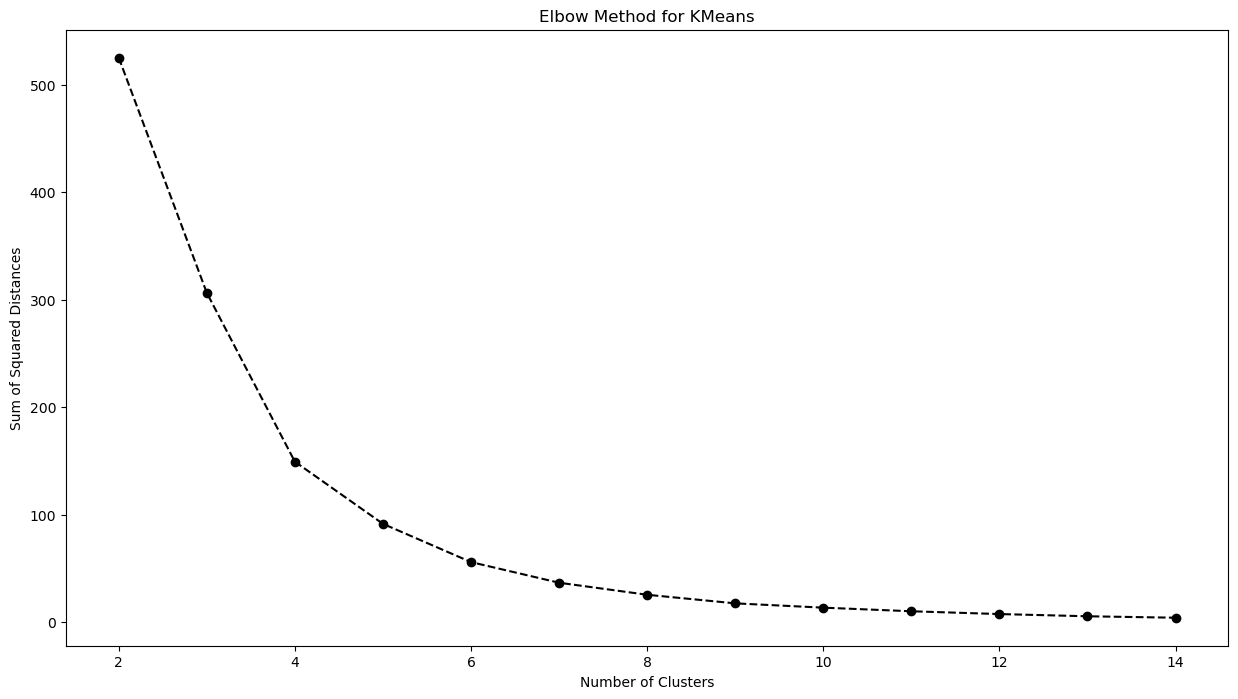

In [29]:
from sklearn.cluster import KMeans

ssd = []

#Finding a value ranging from 2 to 20
for k in range(2, 15):
    kmeans = KMeans(n_clusters = k) #create model of k value
    kmeans.fit(X) 
    ssd.append(kmeans.inertia_) #Storing ssd values for k
    
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(range(2,15),ssd, 'ko--');
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for KMeans');

_We are able to see a significant drop when the number of clusters if 4. That would be our ideal value for k_

**Apply KMeans with the found value of K**

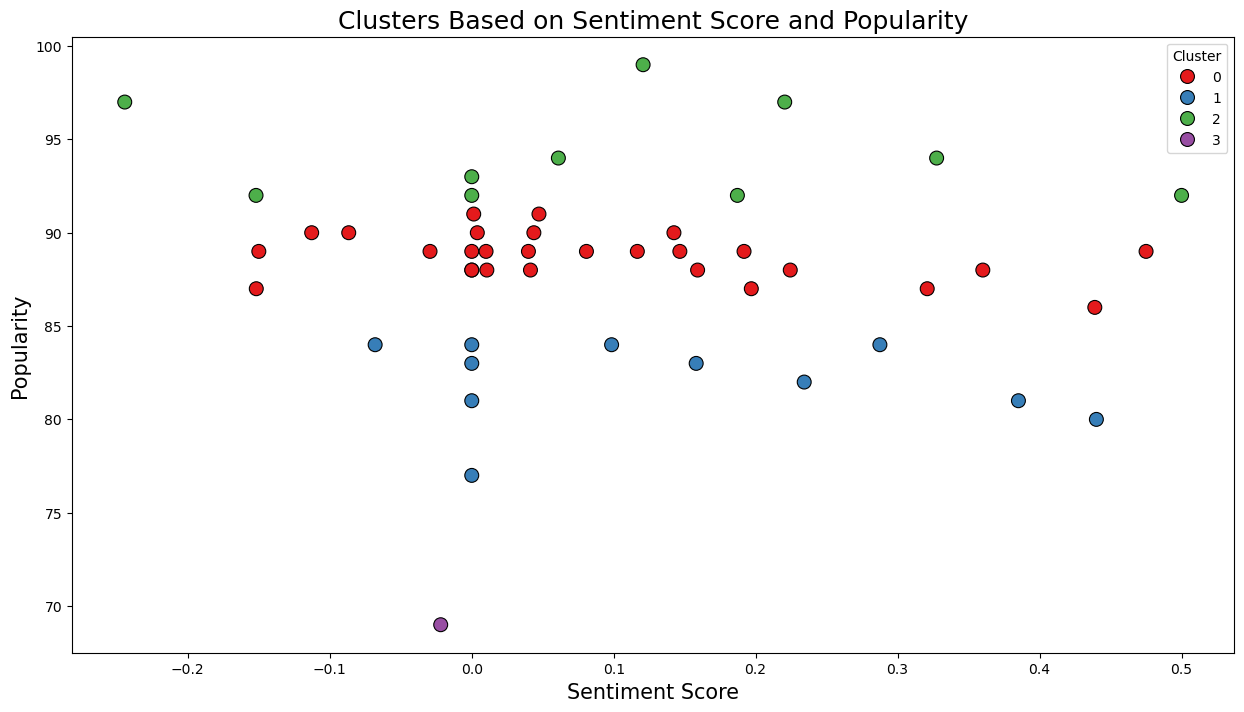

In [34]:
k = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Scatterplot visualization of the clusters based on 'sentiment_score' and 'popularity'
plt.figure(figsize=(15, 8))
sns.scatterplot(x=df['Sentiment Score'], y=df['Popularity'], hue=df['Cluster'], palette='Set1', s=100, edgecolor='black')

# Add titles and labels
plt.title('Clusters Based on Sentiment Score and Popularity', fontsize= 18)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('Popularity', fontsize=15);

**Seen in the graph above, out of all the songs in the top 50 global playlist on Spotify, 80% of them have a positive sentiment**

**Classifying them in different clusters (in this case, 4), based on popularity, they still show a wide variety of sentiment scores across the board**

**I do believe we can see more significant patterns while working with larger scales of data**